<a href="https://colab.research.google.com/github/ndcastillo/Mobile_Channel/blob/main/CanalMovil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelado de un Canal Mobil

La potencia recibida por un receptor puede ser modelado por:

$$P_r = g_c · g_t · g_r · P_t.$$

Usando $g_t=1$ y $g_r=1$, unicamente se modelaria $g_c$ llamado ganancia de canal, el cual tiene cuatro componentes:

$$
g_c=g_d(L)·g_s·g_m
$$

$$g_c (dB) = g_d(dB)+g_s(dB)+g_m(dB) $$
## Perdidas por espacio Libre
La ganancia del canal tiene una parte determinista, la cual decaera con el cuadrado de la distancia entre el transmisor y receptor.
$$
g_d(L)=(\frac{λ}{4πL})^2(\frac{L_0}{L})^{γ-2}≈L^{-γ}
$$
Los valores tipicos de $γ$ son de entre 3 y 5.



Text(0, 0.5, '$g_d(L)$ [dB]')

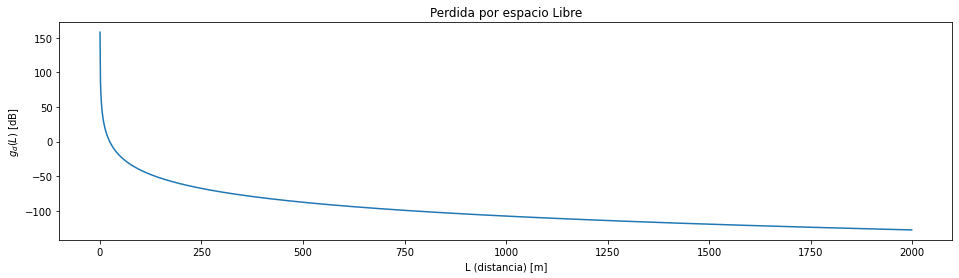

In [ ]:
# Uso de unidades del sistema internacional
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

L = np.arange(0.1,2000,1)
f = 1e6
c = 3e8
Pt = 33
gamma = 2

Pt_db = 10*math.log10(Pt);
wave_length = (c/f)

gd = (((wave_length)/(4*math.pi*L))**2)*((10/L)**(gamma-2))
gd_db = 10*(np.log(gd)/np.log(2))
# aprox_g = L**(-gamma)

plt.figure(figsize=(16,4))
plt.plot(L,gd_db)
plt.title('Perdida por espacio Libre')
plt.xlabel('L (distancia) [m]')
plt.ylabel('$g_d(L)$ [dB]')


## Ganancia de Sombreado (Shadowing gain)
Esta ganancia representara el efecto de las fluctuaciones de la potencia recibida alrededor de un valor principal, esto es causado por los obstaculos que se encuentran entre el transmisor y receptor, ya sean construcciones, vegetaciones, entre otros. Esta ganancia se modela con una variable aleatoria X, definida por:

$$
f_X(X)=\frac{1}{\sqrt{2\pi}\sigma}exp\{-X^2/2\sigma^2\}
$$

donde $X=10log_{10}(g_s)$, y la desviación estandar $\sigma$ se recomienda volres tipicos entre 5 y 10 dB.

De maenra que:

$$g_s (X)= 10^{X/10}$$
$$g_s (X)_{dB} = 10log_{10}(g_s) = X [dB]$$

donde
$$X ~ N(0,\sigma)$$

Text(0, 0.5, '$g_s(x)$ [dB]')

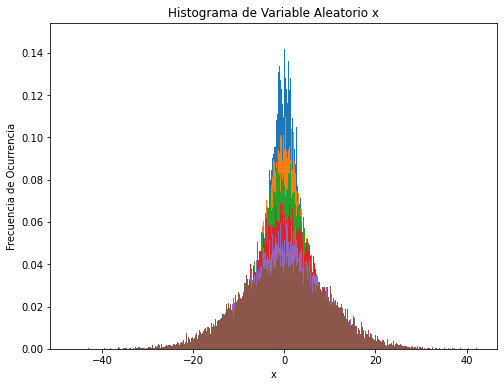

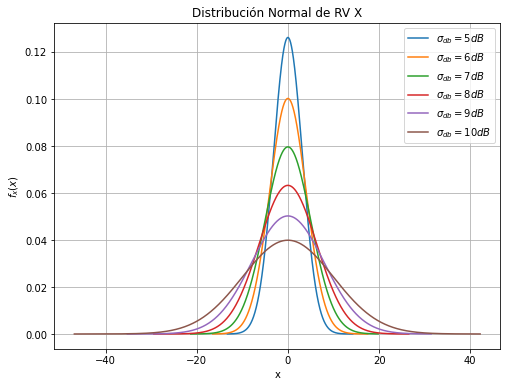

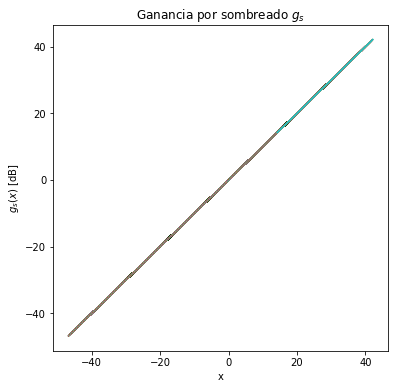

In [ ]:
def gaussian(x, mu, sigma):
  return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*pow((x-mu)/sigma,2))

sigma_db = np.array([5,6,7,8,9,10])
sigma = 10**(sigma_db/10)
longitud = 2000-1;
# longitud = 100;

rv_size = 100000

fig_histograma = plt.figure(figsize=(8,6))
s = np.random.normal(0,sigma[0],rv_size)
count, bins, ignored = plt.hist(s, longitud, density=True)
x = bins

for i in [1,2,3,4,5]:
  s = np.random.normal(0,sigma[i],rv_size)
  count, bins, ignored = plt.hist(s, longitud, density=True)
  x = np.vstack((x,bins))
plt.title('Histograma de Variable Aleatorio x')
plt.xlabel('x')
plt.ylabel('Frecuencia de Ocurrencia')

y = gaussian(x[0], 0, sigma[0])
for i in [1,2,3,4,5]:
  y = np.vstack((y,gaussian(x[i,:], 0, sigma[i])))


fig_distribucion  = plt.figure(figsize=(8,6))
for i in [0,1,2,3,4,5]:
  plt.plot(x[i,:],y[i,:])

plt.grid(True)
plt.legend(['$\sigma_{db} = 5dB$','$\sigma_{db} = 6dB$','$\sigma_{db} = 7dB$',
            '$\sigma_{db} = 8dB$','$\sigma_{db} = 9dB$','$\sigma_{db} = 10dB$'])
plt.title('Distribución Normal de RV X')
plt.xlabel('x')
plt.ylabel('$f_x(x)$')

## Determinación de gs

gs = 10**(x/10)
gs_db = x

fig_gs = plt.figure(figsize=(6,6))
plt.plot(x,gs_db)
plt.title('Ganancia por sombreado $g_s$')
plt.xlabel('x')
plt.ylabel('$g_s(x)$ [dB]')

## Ganancia de desvanecemiento por multicamino

La señal recibida sera una superposición entre señales constructivas y destructivas, por cuanto se debe tomar en cuenta un factor caracteristico que modele este comportamiento. Para ello usamos la ganacia por desvanecimiento por multicamino modelado como:

$$g_m = a^2$$

Y de no tener una linea de vista lo suficientemente presente, a sera una variable aleatoria con distribución de Rayleigh. 

La distribución formal de Rayleigh esta definida por:

$$f(x,\sigma)=\frac{x}{\sigma ^2} exp(\frac{-x^2}{2\sigma^2}); \ \ x>= 0$$

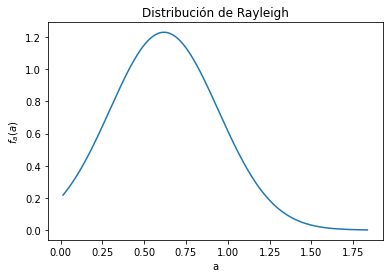

In [ ]:
sigma = [0.5,1,2,3,4,5]
a = np.random.rayleigh(sigma[0],2000)
a = pd.unique(a)
a.sort()

a_mean = a.mean()
a_std = np.std(a)
f_a = gaussian(a, a_mean, a_std)

plt.figure()
plt.plot(a,f_a)
plt.title('Distribución de Rayleigh')
plt.xlabel('a')
plt.ylabel('$f_a(a)$')

gm = a**2
gm_db = 10*np.log(gm)

## Resultado

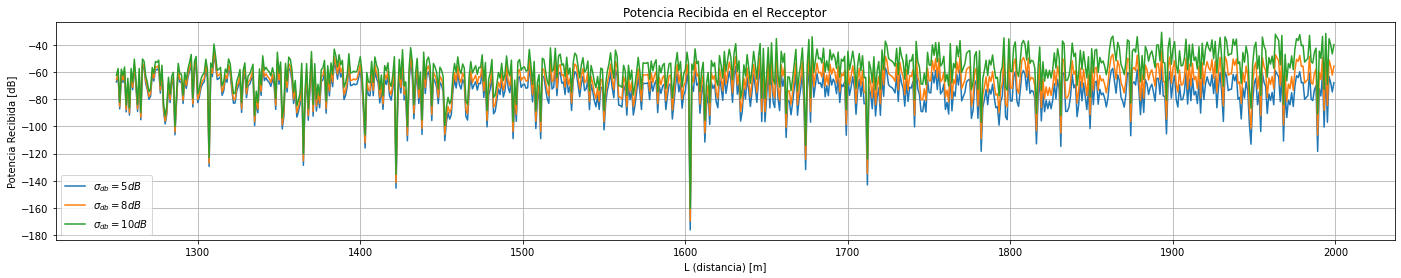

In [ ]:
Pr_db = gd_db + gs_db[0,:] + gm_db + Pt_db
fig_pr = plt.figure(figsize=(24,4))
plt.plot(L[1250:2000],Pr_db[1250:2000])

for i in [3,5]:
  Pr_db = np.vstack((Pr_db,gd_db + gs_db[i,:] + gm_db + Pt_db))
  # fig_pr = plt.figure(figsize=(16,4))
plt.plot(L[1250:2000],Pr_db[1,1250:2000])
plt.plot(L[1250:2000],Pr_db[2,1250:2000])

plt.title('Potencia Recibida en el Recceptor')
plt.xlabel('L (distancia) [m]')
plt.ylabel('Potencia Recibida [dB]')
plt.grid(True)
plt.legend(['$\sigma_{db} = 5dB$',
            '$\sigma_{db} = 8dB$','$\sigma_{db} = 10dB$'])